In [1]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup

In [2]:
random_state = 0
cpu_count = os.cpu_count() - 1
heatmap_cmap = sns.color_palette("Blues", as_cmap=True)

In [3]:
def calculate_metrics(y_test, y_pred):
    accuracy_metric = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    precision_metric = precision_score(y_test, y_pred)
    recall_metric = recall_score(y_test, y_pred)

    return [accuracy_metric, f1_metric, precision_metric, recall_metric]

In [4]:
def print_metrics(y_test, y_pred):
    accuracy_metric = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    precision_metric = precision_score(y_test, y_pred)
    recall_metric = recall_score(y_test, y_pred)
    print(f"accuracy:  {round(accuracy_metric, 2)}")
    print(f"f1:        {round(f1_metric, 2)}")
    print(f"precision: {round(precision_metric, 2)}")
    print(f"recall:    {round(recall_metric, 2)}")

In [5]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
df = pd.read_csv("./data/IMDB Dataset.csv")
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Minimal EDA

In [7]:
labels_distribution = df["sentiment"].value_counts()

Labels distribution:
positive    25000
negative    25000
Name: sentiment, dtype: int64



<AxesSubplot:>

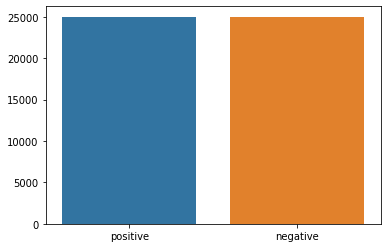

In [8]:
print(f"Labels distribution:\n{labels_distribution}\n")
sns.barplot(x=labels_distribution.index, y=labels_distribution.values)

In [9]:
duplicates = df[df["review"].duplicated()]
print(f"Number of duplicated reviews: {duplicates.shape}")
duplicates.head()

Number of duplicated reviews: (418, 2)


,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative


In [10]:
df = df.drop_duplicates()

## Preprocessing

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [12]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_square_brackets(text):
    return re.sub("\[[^]]*\]", "", text)

def remove_special_characters(text):
    pattern = r"[^a-zA-z0-9\s]"
    text = re.sub(pattern, "", text)
    return text

def clean_text(text):
    text = remove_html(text)
    text = remove_square_brackets(text)
    text = remove_special_characters(text)
    return text

In [13]:
df["review"] = df["review"].apply(clean_text)

In [14]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    toknes = [token.strip() for token in tokens]
    filtered_tokens = list(filter(lambda word: word not in stop_words, tokens))
    lemmatized_text = " ".join([lemmatizer.lemmatize(token) for token in filtered_tokens])

    return lemmatized_text

In [15]:
df["review"] = df["review"].apply(preprocess)

In [16]:
lb = LabelBinarizer()
df["labels"] = lb.fit_transform(df["sentiment"])

## Train/test split

In [17]:
df_train, df_test = train_test_split(
    df,
    random_state=random_state,
    shuffle=True,
)
print(f"Train dataset size: {df_train.shape}")
print(f"Test dataset size: {df_test.shape}")

Train dataset size: (37186, 3)
Test dataset size: (12396, 3)


In [18]:
df_train["sentiment"].value_counts()

positive    18640
negative    18546
Name: sentiment, dtype: int64

In [19]:
df_test["sentiment"].value_counts()

positive    6244
negative    6152
Name: sentiment, dtype: int64

## Feature extraction

#### Count vectorizer

In [20]:
%%time
cv = CountVectorizer(ngram_range=(1,3))
x_train_cv = cv.fit_transform(df_train["review"])
x_test_cv = cv.transform(df_test["review"])

CPU times: user 51.4 s, sys: 1.47 s, total: 52.9 s
Wall time: 53.1 s


#### Tfidf vectorizer

In [21]:
%%time
tv = TfidfVectorizer(ngram_range=(1,3))
x_train_tv = tv.fit_transform(df_train["review"])
x_test_tv = tv.transform(df_test["review"])

CPU times: user 53.2 s, sys: 1.99 s, total: 55.2 s
Wall time: 55.1 s


In [22]:
y_train = df_train["labels"].ravel()
y_test = df_test["labels"].ravel()

## Training

### Logistic regression

In [23]:
%%time
lr_cv = LogisticRegression(
    C=0.001,
    random_state=random_state,
    n_jobs=cpu_count,
).fit(x_train_cv, y_train)

CPU times: user 677 ms, sys: 753 ms, total: 1.43 s
Wall time: 45.9 s


In [24]:
%%time
lr_tv = LogisticRegression(
    C=0.15,
    random_state=random_state,
    n_jobs=cpu_count,
).fit(x_train_tv, y_train)

CPU times: user 112 ms, sys: 136 ms, total: 248 ms
Wall time: 47.7 s


In [25]:
y_pred_lr_cv = lr_cv.predict(x_test_cv)
y_pred_lr_tv = lr_tv.predict(x_test_tv)

In [26]:
y_pred_train_lr_cv = lr_cv.predict(x_train_cv)
y_pred_train_lr_tv = lr_tv.predict(x_train_tv)

In [27]:
print("Test metrics for logistic regression + count vectorizer:")
print_metrics(y_test, y_pred_lr_cv)
print("\nTrain metrics for logistic regression + count vectorizer:")
print_metrics(y_train, y_pred_train_lr_cv)

Test metrics for logistic regression + count vectorizer:
accuracy:  0.86
f1:        0.86
precision: 0.85
recall:    0.88

Train metrics for logistic regression + count vectorizer:
accuracy:  0.89
f1:        0.9
precision: 0.88
recall:    0.91


In [28]:
print("Test metrics for logistic regression + tfidf vectorizer:")
print_metrics(y_test, y_pred_lr_tv)
print("\nTrain metrics for logistic regression + tfidf vectorizer:")
print_metrics(y_train, y_pred_train_lr_tv)

Test metrics for logistic regression + tfidf vectorizer:
accuracy:  0.85
f1:        0.85
precision: 0.85
recall:    0.86

Train metrics for logistic regression + tfidf vectorizer:
accuracy:  0.9
f1:        0.9
precision: 0.88
recall:    0.93


<AxesSubplot:>

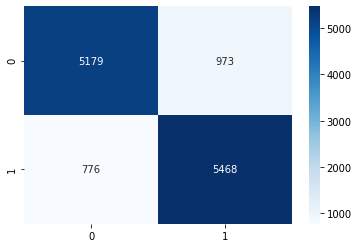

In [29]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr_cv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

<AxesSubplot:>

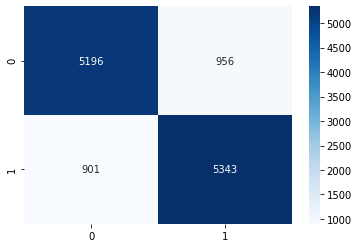

In [30]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr_tv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

### SGD classifier

In [31]:
%%time
sgdc_cv = SGDClassifier(
    loss="log",
    alpha=0.075,
    random_state=random_state,
    n_jobs=cpu_count,
).fit(x_train_cv, y_train)

CPU times: user 2.26 s, sys: 545 ms, total: 2.81 s
Wall time: 1.75 s


In [32]:
%%time
sgdc_tv = SGDClassifier(
    loss="log",
    alpha=0.0002,
    random_state=random_state,
    n_jobs=cpu_count,
).fit(x_train_tv, y_train)

CPU times: user 2.09 s, sys: 537 ms, total: 2.63 s
Wall time: 1.62 s


In [33]:
y_pred_sgdc_cv = sgdc_cv.predict(x_test_cv)
y_pred_sgdc_tv = sgdc_tv.predict(x_test_tv)

In [34]:
y_pred_train_sgdc_cv = sgdc_cv.predict(x_train_cv)
y_pred_train_sgdc_tv = sgdc_tv.predict(x_train_tv)

In [35]:
print("Test metrics for sgd classifier + count vectorizer:")
print_metrics(y_test, y_pred_sgdc_cv)
print("\nTrain metrics for sgd classifier + count vectorizer:")
print_metrics(y_train, y_pred_train_sgdc_cv)

Test metrics for sgd classifier + count vectorizer:
accuracy:  0.84
f1:        0.84
precision: 0.84
recall:    0.85

Train metrics for sgd classifier + count vectorizer:
accuracy:  0.86
f1:        0.87
precision: 0.86
recall:    0.88


In [36]:
print("Test metrics for sgd classifier + tfidf vectorizer:")
print_metrics(y_test, y_pred_sgdc_tv)
print("\nTrain metrics for sgd classifier + tfidf vectorizer:")
print_metrics(y_train, y_pred_train_sgdc_tv)

Test metrics for sgd classifier + tfidf vectorizer:
accuracy:  0.85
f1:        0.85
precision: 0.85
recall:    0.85

Train metrics for sgd classifier + tfidf vectorizer:
accuracy:  0.9
f1:        0.9
precision: 0.88
recall:    0.92


<AxesSubplot:>

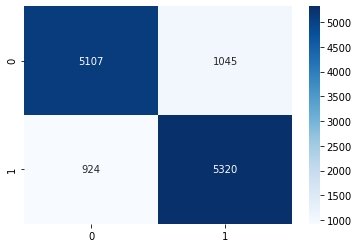

In [37]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_sgdc_cv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

<AxesSubplot:>

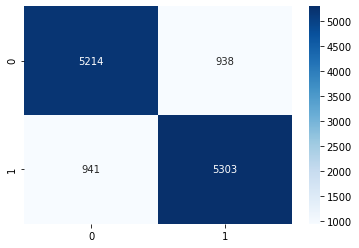

In [38]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_sgdc_tv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

### Dummy classifier

In [39]:
%%time
dc_cv = DummyClassifier(
    random_state=random_state
).fit(x_train_cv, y_train)

CPU times: user 45 ms, sys: 20.2 ms, total: 65.2 ms
Wall time: 94.8 ms


/media/mia/mia/hdd/Documents/KPI/semester_7/SSHI/lab1/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [40]:
%%time
dc_tv = DummyClassifier(
    random_state=random_state
).fit(x_train_tv, y_train)

CPU times: user 8.02 ms, sys: 159 µs, total: 8.17 ms
Wall time: 6.14 ms


In [41]:
y_pred_dc_cv = dc_cv.predict(x_test_cv)
y_pred_dc_tv = dc_tv.predict(x_test_tv)

In [42]:
dc_cv_score = accuracy_score(y_test, y_pred_dc_cv)
dc_tv_score = accuracy_score(y_test, y_pred_dc_tv)

In [43]:
y_pred_train_dc_cv = dc_cv.predict(x_train_cv)
y_pred_train_dc_tv = dc_tv.predict(x_train_tv)

In [44]:
print("Test metrics for dummy classifier + count vectorizer:")
print_metrics(y_test, y_pred_dc_cv)
print("\nTrain metrics for dummy classifier + count vectorizer:")
print_metrics(y_train, y_pred_train_dc_cv)

Test metrics for dummy classifier + count vectorizer:
accuracy:  0.5
f1:        0.51
precision: 0.5
recall:    0.51

Train metrics for dummy classifier + count vectorizer:
accuracy:  0.5
f1:        0.5
precision: 0.5
recall:    0.5


In [45]:
print("Test metrics for dummy classifier + tfidf vectorizer:")
print_metrics(y_test, y_pred_dc_tv)
print("\nTrain metrics for dummy classifier + tfidf vectorizer:")
print_metrics(y_train, y_pred_train_dc_tv)

Test metrics for dummy classifier + tfidf vectorizer:
accuracy:  0.5
f1:        0.51
precision: 0.5
recall:    0.51

Train metrics for dummy classifier + tfidf vectorizer:
accuracy:  0.5
f1:        0.5
precision: 0.5
recall:    0.5


<AxesSubplot:>

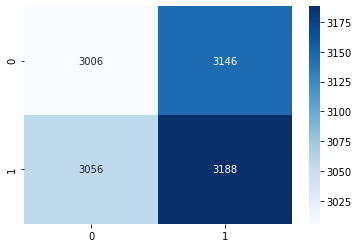

In [46]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_dc_cv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

<AxesSubplot:>

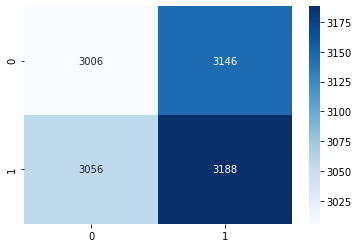

In [47]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_dc_tv),
    annot=True,
    fmt="d",
    cmap=heatmap_cmap,
)

## Summary

In [48]:
scores_with_dummy = pd.DataFrame(
    [
        calculate_metrics(y_test, y_pred_lr_cv),
        calculate_metrics(y_test, y_pred_lr_tv),
        calculate_metrics(y_test, y_pred_sgdc_cv),
        calculate_metrics(y_test, y_pred_sgdc_tv),
        calculate_metrics(y_test, y_pred_dc_cv),
        calculate_metrics(y_test, y_pred_dc_tv),
    ],
    columns=["accuracy", "f1", "precision", "recall"],
    index=["LR + CV", "LR + TV", "SGD + CV", "SGD + TV", "DC + CV", "DC + TV"]
)

scores_without_dummy = pd.DataFrame(
    [
        calculate_metrics(y_test, y_pred_lr_cv),
        calculate_metrics(y_test, y_pred_lr_tv),
        calculate_metrics(y_test, y_pred_sgdc_cv),
        calculate_metrics(y_test, y_pred_sgdc_tv),
    ],
    columns=["accuracy", "f1", "precision", "recall"],
    index=["LR + CV", "LR + TV", "SGD + CV", "SGD + TV"]
)

In [49]:
scores_with_dummy

,accuracy,f1,precision,recall
LR + CV,0.858906,0.862121,0.848937,0.875721
LR + TV,0.850194,0.851949,0.848230,0.855701
SGD + CV,0.841158,0.843842,0.835821,0.852018
SGD + TV,0.848419,0.849499,0.849704,0.849295
DC + CV,0.499677,0.506917,0.503315,0.510570
DC + TV,0.499677,0.506917,0.503315,0.510570


In [50]:
scores_without_dummy

,accuracy,f1,precision,recall
LR + CV,0.858906,0.862121,0.848937,0.875721
LR + TV,0.850194,0.851949,0.848230,0.855701
SGD + CV,0.841158,0.843842,0.835821,0.852018
SGD + TV,0.848419,0.849499,0.849704,0.849295


<AxesSubplot:>

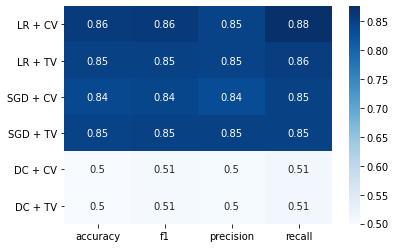

In [51]:
sns.heatmap(
    scores_with_dummy,
    annot=True,
    cmap=heatmap_cmap,
)

<AxesSubplot:>

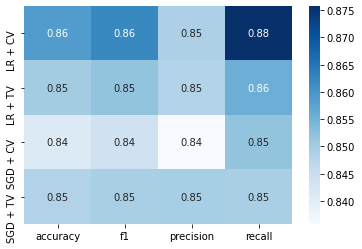

In [52]:
sns.heatmap(
    scores_without_dummy,
    annot=True,
    cmap=heatmap_cmap,
)